In [2]:
import torch

n_samples = 1000
input_dim = 10
output_dim = 2

#generate synthetic dataset
data = torch.randn(n_samples, input_dim)
W_true = torch.tensor([[0.5,1], [1.0,1], [-0.5,0.5], [1.5,0], [2,0.4], [0.5,-0.2], [3,1.5], [-0.25,2], [1,2], [0.75,-2]])
y_true = data @ W_true + torch.randn(n_samples, output_dim) * 0.1

# Train/test split
train_ratio = 0.75
n_train = int(n_samples * train_ratio)
X_train, X_test = data[:n_train], data[n_train:]
y_train, y_test = y_true[:n_train], y_true[n_train:]

In [37]:
import torch
from torch.autograd import Function

import qpth.solvers as solvers
from qpth.solvers.pdipm import batch as pdipm_b
from qpth.solvers.pdipm import spbatch as pdipm_spb
from qpth.util import bger, expandParam, extract_nBatch

# from .solvers.pdipm import single as pdipm_s

from enum import Enum


class QPSolvers(Enum):
    PDIPM_BATCHED = 1
    CVXPY = 2

class QPFunctionFn(Function):
    @staticmethod
    def forward(ctx, Q_, p_, G_, h_, A_, b_, eps=1e-12, verbose=0, notImprovedLim=3,
                 maxIter=20, solver=QPSolvers.PDIPM_BATCHED,
                 check_Q_spd=True):
            nBatch = extract_nBatch(Q_, p_, G_, h_, A_, b_)
            Q, _ = expandParam(Q_, nBatch, 3)
            p, _ = expandParam(p_, nBatch, 2)
            G, _ = expandParam(G_, nBatch, 3)
            h, _ = expandParam(h_, nBatch, 2)
            A, _ = expandParam(A_, nBatch, 3)
            b, _ = expandParam(b_, nBatch, 2)

            if check_Q_spd:
                for i in range(nBatch):
                    try:
                        torch.linalg.cholesky(Q)
                    except:
                        raise RuntimeError('Q is not SPD.')

            _, nineq, nz = G.size()
            neq = A.size(1) if A.nelement() > 0 else 0
            assert(neq > 0 or nineq > 0)
            ctx.neq, ctx.nineq, ctx.nz = neq, nineq, nz

            if solver == QPSolvers.PDIPM_BATCHED:
                ctx.Q_LU, ctx.S_LU, ctx.R = pdipm_b.pre_factor_kkt(Q, G, A)
                zhats, ctx.nus, ctx.lams, ctx.slacks = pdipm_b.forward(
                    Q, p, G, h, A, b, ctx.Q_LU, ctx.S_LU, ctx.R,
                    eps, verbose, notImprovedLim, maxIter)
            elif solver == QPSolvers.CVXPY:
                vals = torch.Tensor(nBatch).type_as(Q)
                zhats = torch.Tensor(nBatch, ctx.nz).type_as(Q)
                lams = torch.Tensor(nBatch, ctx.nineq).type_as(Q)
                nus = torch.Tensor(nBatch, ctx.neq).type_as(Q) \
                    if ctx.neq > 0 else torch.Tensor()
                slacks = torch.Tensor(nBatch, ctx.nineq).type_as(Q)
                for i in range(nBatch):
                    Ai, bi = (A[i], b[i]) if neq > 0 else (None, None)
                    vals[i], zhati, nui, lami, si = solvers.cvxpy.forward_single_np(
                        *[x.cpu().numpy() if x is not None else None
                        for x in (Q[i], p[i], G[i], h[i], Ai, bi)])
                    # if zhati[0] is None:
                    #     import IPython, sys; IPython.embed(); sys.exit(-1)
                    zhats[i] = torch.Tensor(zhati)
                    lams[i] = torch.Tensor(lami)
                    slacks[i] = torch.Tensor(si)
                    if neq > 0:
                        nus[i] = torch.Tensor(nui)

                ctx.vals = vals
                ctx.lams = lams
                ctx.nus = nus
                ctx.slacks = slacks
            else:
                assert False
            ctx.solver = solver
            ctx.save_for_backward(zhats, Q_, p_, G_, h_, A_, b_)
            return zhats
    @staticmethod
    def backward(ctx, dl_dzhat):
            zhats, Q, p, G, h, A, b = ctx.saved_tensors
            nBatch = extract_nBatch(Q, p, G, h, A, b)
            Q, Q_e = expandParam(Q, nBatch, 3)
            p, p_e = expandParam(p, nBatch, 2)
            G, G_e = expandParam(G, nBatch, 3)
            h, h_e = expandParam(h, nBatch, 2)
            A, A_e = expandParam(A, nBatch, 3)
            b, b_e = expandParam(b, nBatch, 2)

            # neq, nineq, nz = ctx.neq, ctx.nineq, ctx.nz
            neq, nineq = ctx.neq, ctx.nineq

            solver = ctx.solver
            if solver == QPSolvers.CVXPY:
                ctx.Q_LU, ctx.S_LU, ctx.R = pdipm_b.pre_factor_kkt(Q, G, A)

            # Clamp here to avoid issues coming up when the slacks are too small.
            # TODO: A better fix would be to get lams and slacks from the
            # solver that don't have this issue.
            d = torch.clamp(ctx.lams, min=1e-8) / torch.clamp(ctx.slacks, min=1e-8)

            pdipm_b.factor_kkt(ctx.S_LU, ctx.R, d)
            dx, _, dlam, dnu = pdipm_b.solve_kkt(
                ctx.Q_LU, d, G, A, ctx.S_LU,
                dl_dzhat, torch.zeros(nBatch, nineq).type_as(G),
                torch.zeros(nBatch, nineq).type_as(G),
                torch.zeros(nBatch, neq).type_as(G) if neq > 0 else torch.Tensor())

            dps = dx
            dGs = bger(dlam, zhats) + bger(ctx.lams, dx)
            if G_e:
                dGs = dGs.mean(0)
            dhs = -dlam
            if h_e:
                dhs = dhs.mean(0)
            if neq > 0:
                dAs = bger(dnu, zhats) + bger(ctx.nus, dx)
                dbs = -dnu
                if A_e:
                    dAs = dAs.mean(0)
                if b_e:
                    dbs = dbs.mean(0)
            else:
                dAs, dbs = None, None
            dQs = 0.5 * (bger(dx, zhats) + bger(zhats, dx))
            if Q_e:
                dQs = dQs.mean(0)
            if p_e:
                dps = dps.mean(0)


            grads = (dQs, dps, dGs, dhs, dAs, dbs, None)

            return grads



def QPFunction(Q, p, G, h, A, b, verbose=-1, *args, **kwargs):
    return QPFunctionFn.apply(Q, p, G, h, A, b, verbose, *args, **kwargs)

In [38]:
import torch.nn as nn
from qpth.qp import QPFunction

class QPLayer(nn.Module):
    def __init__(self):
        super(QPLayer, self).__init__()

    def forward(self, Q, p, G, h, A, b):
        return QPFunction(verbose=-1)(Q, p, G, h, A, b)

class QPsimplenetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QPsimplenetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)
        self.optnet_layer = OptNetLayer()

    def forward(self, x):
        Q = torch.eye(output_dim).unsqueeze(0).repeat(x.shape[0], 1, 1)
        p = -self.fc1(x)
        G = torch.zeros(x.shape[0], output_dim, output_dim)
        h = torch.zeros(x.shape[0], output_dim)
        A = torch.zeros(x.shape[0], 0, output_dim)
        b = torch.zeros(x.shape[0], 0)
        return self.optnet_layer(Q, p, G, h, A, b)


In [39]:
# Training parameters
learning_rate = 0.01
n_epochs = 400

model = QPsimplenetwork(input_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_display=[]
# Training loop
for epoch in range(n_epochs):
    # Forward pass
    y_pred = model(X_train)

    # Compute loss
    loss = criterion(y_pred, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_display.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    test_loss = criterion(y_test_pred, y_test)
    print(f"Test Loss: {test_loss.item():.4f}")

Epoch [10/400], Loss: 17.1251
Epoch [20/400], Loss: 15.1389
Epoch [30/400], Loss: 13.4046
Epoch [40/400], Loss: 11.8931
Epoch [50/400], Loss: 10.5726
Epoch [60/400], Loss: 9.4149
Epoch [70/400], Loss: 8.3978
Epoch [80/400], Loss: 7.5033
Epoch [90/400], Loss: 6.7163
Epoch [100/400], Loss: 6.0228
Epoch [110/400], Loss: 5.4106
Epoch [120/400], Loss: 4.8684
Epoch [130/400], Loss: 4.3869
Epoch [140/400], Loss: 3.9578
Epoch [150/400], Loss: 3.5739
Epoch [160/400], Loss: 3.2295
Epoch [170/400], Loss: 2.9195
Epoch [180/400], Loss: 2.6397
Epoch [190/400], Loss: 2.3867
Epoch [200/400], Loss: 2.1573
Epoch [210/400], Loss: 1.9492
Epoch [220/400], Loss: 1.7601
Epoch [230/400], Loss: 1.5882
Epoch [240/400], Loss: 1.4320
Epoch [250/400], Loss: 1.2900
Epoch [260/400], Loss: 1.1609
Epoch [270/400], Loss: 1.0436
Epoch [280/400], Loss: 0.9371
Epoch [290/400], Loss: 0.8405
Epoch [300/400], Loss: 0.7530
Epoch [310/400], Loss: 0.6737
Epoch [320/400], Loss: 0.6021
Epoch [330/400], Loss: 0.5373
Epoch [340/400

Text(0, 0.5, 'Training loss')

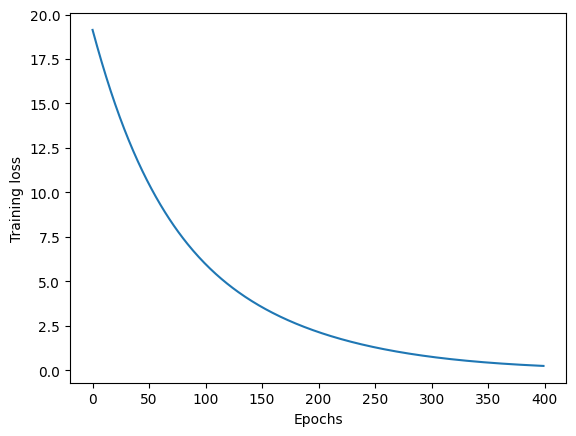

In [40]:
import matplotlib.pyplot as plt
plt.plot(loss_display)
plt.xlabel("Epochs")
plt.ylabel("Training loss")